In [1]:
import pandas as pd
import cv2
import numpy as np
from pylab import *
import fractions
import torch
import torchvision.ops.boxes as bops
iris_df = pd.read_csv("iris_annotation.csv")
images = "data/" + iris_df['image'].astype(str) 
# nech mam kompletnu cestu
IoUThreshold = 0.75

In [2]:
iris_df = pd.read_csv("iris_annotation.csv")
images = "data/" + iris_df['image'].astype(str) 

In [3]:
def insertPupil(found_row, img):
    center_coordinates = (int(found_row[' center_x_1']), int(found_row[' center_y_1']))
    radius = int(found_row[' polomer_1'])
    return cv2.circle(img, center_coordinates, radius, (255, 0, 0), 3)

def insertIris(found_row, img):
    center_coordinates = (int(found_row[' center_x_2']), int(found_row[' center_y_2']))
    radius = int(found_row[' polomer_2'])
    return cv2.circle(img, center_coordinates, radius, (255, 0, 0), 3)


def getPBox(found_row,img):
    radius = int(found_row[' polomer_1'])
    topLeftX = int(found_row[' center_x_1']) - radius
    topLeftY = int(found_row[' center_y_1']) - radius
    bottomRightX = int(found_row[' center_x_1']) + radius
    bottomRightY = int(found_row[' center_y_1']) + radius
    return topLeftX,topLeftY,bottomRightX,bottomRightY

def getIBox(found_row,img):
    radius = int(found_row[' polomer_2'])
    topLeftX = int(found_row[' center_x_2']) - radius
    topLeftY = int(found_row[' center_y_2']) - radius
    bottomRightX = int(found_row[' center_x_2']) + radius
    bottomRightY = int(found_row[' center_y_2']) + radius
    return topLeftX,topLeftY,bottomRightX,bottomRightY

def getBox(circle):
    radius = int(circle[2])
    topLeftX = int(circle[0]) - radius
    topLeftY = int(circle[1]) - radius
    bottomRightX = int(circle[0]) + radius
    bottomRightY = int(circle[1]) + radius
    return topLeftX,topLeftY,bottomRightX,bottomRightY
    
    
def calculate_precision(TP,FP):
    if(TP+FP) > 0:
        return round(TP/(TP+FP),2)
    else: 
        return 0
    
def calculate_recall(TP,FN):
    if(TP+FN) > 0:
        return round(TP/(TP+FN),2)
    else: 
        return 0

In [4]:
# https://stackoverflow.com/questions/19534165/tkinter-scale-in-realtime
# https://stackoverflow.com/questions/25745011/how-to-use-tkinter-slider-scale-widget-with-discrete-steps
# https://www.geeksforgeeks.org/python-tkinter-text-widget/
# https://pythonbasics.org/tkinter-checkbox/
    
    
from tkinter import *

base = Tk()
base.title("Settings")
varEqualize = IntVar()
varGauss = IntVar()
varCanny = IntVar()
varHough = IntVar()
varSpoiler = IntVar()

magic = 0 #len moje oznacenie indexu obrazku

windowName = images[magic] 
gray_iris = cv2.imread(images[magic],cv2.COLOR_BGR2GRAY)
cv2.imshow(windowName, gray_iris)

def action(value=None):
    equalize = varEqualize.get()
    gauss = varGauss.get()
    canny = varCanny.get()
    hough = varHough.get()
    spoiler = varSpoiler.get()
    
    ksize = Xvelkost_jadra.get()
    sigma = Xparameter_sigma.get()
    
    threshold1 = Xthreshold1.get()
    threshold2 = Xthreshold2.get()
    aperture = Xaperture.get()
    
    dp = Xdp.get()
    minDist = XminDist.get()
    param1 = Xparam1.get()
    param2 = Xparam2.get()
    minRadius = XminRadius.get()
    maxRadius = XmaxRadius.get()
    
    if equalize:
        main_iris = cv2.equalizeHist(gray_iris.copy())
        cv2.imshow(windowName,main_iris)
    else:
        main_iris = gray_iris.copy()
        cv2.imshow(windowName,gray_iris)
        
    if (ksize %  2 ) != 0 and gauss:
        gauss_iris = cv2.GaussianBlur(main_iris,(ksize,ksize), sigma)
        cv2.imshow(windowName, gauss_iris)
        gauss_defined = True
    else:
        gauss_defined = False
        
    if canny:
        if gauss_defined:
            if aperture == 3 or aperture == 5 or aperture == 7:
                canny_iris = cv2.Canny(gauss_iris,threshold1,threshold2,apertureSize=aperture)
            else:
                canny_iris = cv2.Canny(gauss_iris,threshold1,threshold2)
            cv2.imshow(windowName, canny_iris)
        else:
            if aperture == 3 or aperture == 5 or aperture == 7:
                canny_iris = cv2.Canny(main_iris,threshold1,threshold2,apertureSize=aperture)
            else:
                canny_iris = cv2.Canny(main_iris,threshold1,threshold2)
            cv2.imshow(windowName, canny_iris)
    
    if hough:
        circles = None
        if canny:
            circles = cv2.HoughCircles(canny_iris,cv2.HOUGH_GRADIENT,dp = dp,minDist = minDist,param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)
        elif gauss_defined:
            circles = cv2.HoughCircles(gauss_iris,cv2.HOUGH_GRADIENT,dp = dp,minDist = minDist,param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)
        else:
            circles = cv2.HoughCircles(gray_iris,cv2.HOUGH_GRADIENT,dp = dp,minDist = minDist,param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)

        cimg1 = cv2.cvtColor(gray_iris,cv2.COLOR_GRAY2BGR).copy()
        found_row = iris_df.iloc[[magic]]
        boxP = torch.tensor([getPBox(found_row,cimg1)])
        boxI = torch.tensor([getIBox(found_row,cimg1)])
        global TP
        TP=0
        global FP
        FP=0
        global FN
        FN=0
        
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0,:]:
                box = torch.tensor([getBox(circle)])
                cv2.circle(cimg1,(circle[0],circle[1]),circle[2],(0,255,0),2) #draw the outer circle
                if circle[2]>70:
                    iou = bops.box_iou(box,boxI)
                    iou = round(iou.numpy()[0][0],2)
                    if(iou>=IoUThreshold):
                        TP+=1
                    else:
                        FP+=1
                else:
                    iou = bops.box_iou(box,boxP)
                    iou = round(iou.numpy()[0][0],2)
                    if(iou>=IoUThreshold):
                        TP+=1
                    else:
                        FP+=1
                FN = 2 - TP
                if(FN!=0 and FN!=1 and FN!=2):
                    FN=0

        precision = calculate_precision(TP,FP)
        recall = calculate_recall(TP,FN)
        line = "TP :" + str(TP) + " FP:" + str(FP) + " FN:" + str(FN) + " P:" + str(precision) + " R:" + str(recall)
        cv2.putText(img = cimg1, text = line,org=(15,15),fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(255, 0, 0),thickness=1)           
        cv2.imshow(windowName,cimg1)
        
    if spoiler:
        new_iris = gray_iris.copy()
        new_iris = cv2.cvtColor(new_iris, cv2.COLOR_RGB2BGR)
        new_iris = cv2.circle(new_iris, (iris_df[' center_x_1'][magic],iris_df[' center_y_1'][magic]),iris_df[' polomer_1'][magic],(0,0,255),2)
        new_iris = cv2.circle(new_iris, (iris_df[' center_x_2'][magic],iris_df[' center_y_2'][magic]),iris_df[' polomer_2'][magic],(0,0,255),2)
        new_iris = cv2.circle(new_iris, (iris_df[' center_x_3'][magic],iris_df[' center_y_3'][magic]),iris_df[' polomer_3'][magic],(0,255,255),2)
        new_iris = cv2.circle(new_iris, (iris_df[' center_x_4'][magic],iris_df['center_y_4'][magic]),iris_df[' polomer_4'][magic],(0,255,255),2)
        cv2.imshow(windowName,new_iris)  


# button=Button(base,text='exit',command=action)
# button.pack()


checkEqualize = Checkbutton(base, text='Equalize',variable = varEqualize,onvalue=1, offvalue=0, command=action)
checkEqualize.pack()

l = Label(base, text="Velkost jadra")
Xvelkost_jadra = Scale(base,from_ = 1, to = 50,tickinterval=2,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xvelkost_jadra.pack()
l = Label(base, text="Parameter sigma")
Xparameter_sigma = Scale(base,from_ = 0, to = 50,tickinterval=5,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xparameter_sigma.pack()
checkGauss = Checkbutton(base, text='Gaussian blur',variable = varGauss,onvalue=1, offvalue=0, command=action)
checkGauss.pack()


l = Label(base, text="Threshold1")
Xthreshold1 = Scale(base,from_ = 0, to = 255,tickinterval=25,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xthreshold1.pack()
l = Label(base, text="Threshold2")
Xthreshold2 = Scale(base,from_ = 0, to = 255,tickinterval=25,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xthreshold2.pack()
l = Label(base, text="Aperture")
Xaperture = Scale(base,from_ = 3, to = 7,tickinterval=1,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xaperture.pack()
checkCanny = Checkbutton(base, text='Canny edge',variable = varCanny,onvalue=1, offvalue=0, command=action)
checkCanny.pack()


l = Label(base, text="Dp")
Xdp = Scale(base,from_ = 1, to = 10,tickinterval=1,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xdp.pack()
l = Label(base, text="minDist")
XminDist = Scale(base,from_ = 1, to = 100,tickinterval=10,length=500, orient=HORIZONTAL,command=action)
l.pack()
XminDist.pack()
l = Label(base, text="param1")
Xparam1 = Scale(base,from_ = 1, to = 500,tickinterval=50,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xparam1.pack()
l = Label(base, text="param2")
Xparam2 = Scale(base,from_ = 1, to = 500,tickinterval=50,length=500, orient=HORIZONTAL,command=action)
l.pack()
Xparam2.pack()
l = Label(base, text="minRadius")
XminRadius = Scale(base,from_ = 0, to = 100,tickinterval=10,length=500, orient=HORIZONTAL,command=action)
l.pack()
XminRadius.pack()
l = Label(base, text="maxRadius")
XmaxRadius = Scale(base,from_ = 0, to = 255,tickinterval=25,length=500, orient=HORIZONTAL,command=action)
l.pack()
XmaxRadius.pack()
checkHough = Checkbutton(base, text='Hough circles',variable = varHough,onvalue=1, offvalue=0, command=action)
checkHough.pack()

checkSpoiler = Checkbutton(base, text='Spoiler',variable = varSpoiler, onvalue=1, offvalue=0, command=action)
checkSpoiler.pack()


base.mainloop()
cv2.destroyAllWindows()

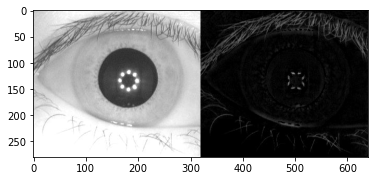

In [130]:
kernel = np.ones((11,11),np.uint8)
new_iris = cv2.morphologyEx(gray_iris,cv2.MORPH_BLACKHAT,kernel)
imshow(np.hstack([gray_iris,new_iris]),cmap='gray')

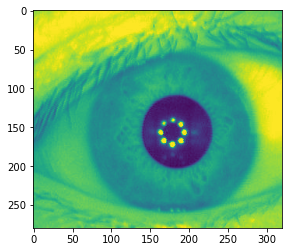

In [72]:
tobedeleted = []
for i in range(len(images)):
    try:
        gray_iris = cv2.imread(images[i],cv2.COLOR_BGR2GRAY)
        imshow(gray_iris)
    except:
        tobedeleted.append(i)

In [73]:
working_df = iris_df.copy()
working_df.drop(index=tobedeleted,inplace=True)
working_df = working_df.reset_index()
working_df = working_df.drop('index',1)
workingImages = "data/" + working_df['image'].astype(str) 
print(len(workingImages))

2636


In [89]:
statistics = []
results = []

for generated_maxRadius in range(200,201,1):
    for generated_minRadius in range(30,31,1):
        for generated_param2 in range(51,52,1):
            for generated_param1 in range(101,102,1):
                for generated_minDist in range(1,2,1): 
                    for generated_sigma in range(5,6,1):
                        for generated_ksize in range(9,10,1):
                            for i in range(len(working_df)): #Nejdem to bezat pre cely dataset kokso
                                gray_iris = cv2.imread(workingImages[i],cv2.COLOR_BGR2GRAY)
                                found_row = working_df.iloc[[i]]
                                eq_iris = cv2.equalizeHist(gray_iris)
                                gauss_iris = cv2.GaussianBlur(eq_iris,(generated_ksize,generated_ksize),generated_sigma)
                                circles = None
                                circles = cv2.HoughCircles(gauss_iris, cv2.HOUGH_GRADIENT,dp = 1,minDist = generated_minDist, param1 = generated_param1, param2 = generated_param2, minRadius = generated_minRadius, maxRadius = generated_maxRadius)
                                cimg1 = cv2.cvtColor(gray_iris,cv2.COLOR_GRAY2BGR).copy()

                                boxP = torch.tensor([getPBox(found_row,cimg1)])
                                boxI = torch.tensor([getIBox(found_row,cimg1)])
                                if circles is not None:
                                    TP = 0
                                    FP = 0
                                    FN = 0
                                    avgIou = []
                                    bestIrisIou = [0]
                                    bestPupilIou =[0]
                                    circles = np.uint16(np.around(circles))
                                    for circle in circles[0,:]:
                                        box = torch.tensor([getBox(circle)])
                                        cv2.circle(cimg1,(circle[0],circle[1]), circle[2],(0,255,0),3)
                                        if circle[2] > 70: #ak je polomer viac ako 70, kontrolujem s IRIS
                                            iou = bops.box_iou(box,boxI)
                                            iou = round(iou.numpy()[0][0],2)
                                            avgIou.append(iou)
                                            if(iou>=IoUThreshold):
                                                bestIrisIou.append(iou)
                                                TP +=1 
                                            else:
                                                FP += 1
                                        else:
                                            iou = bops.box_iou(box,boxP)
                                            iou = round(iou.numpy()[0][0],2)
                                            avgIou.append(iou)
                                            if(iou>=IoUThreshold):
                                                bestPupilIou.append(iou)
                                                TP +=1
                                            else:
                                                FP +=1
                                        FN = 2 - TP #Mame iris a pupil
                                        if(FN!=0 and FN!=1 and FN!=2):
                                            FN = 0

                                precision = calculate_precision(TP,FP)   
                                recall = calculate_recall(TP,FN)
                                averageIou = round(sum(avgIou)/len(avgIou),2)
                                bestIris = max(bestIrisIou)
                                bestPupil = max(bestPupilIou)
                                statistics.append([generated_ksize,generated_sigma,generated_minDist,generated_param1,generated_param2,generated_minRadius,generated_maxRadius, precision,recall,averageIou,bestIris,bestPupil,TP,FP,FN])
                            stats = np.array(statistics)
                            wanted = np.around(stats.mean(axis=0),decimals=2)
                            results.append(wanted)
                            statistics=[]

In [90]:
DF = pd.DataFrame(results)
DF.columns=['ksize','sigma','minDist','param1','param2','minRadius','maxRadius', 'averagePrecision','averageRecall', 'averageIoU', 'averageBestIris','averageBestPupil','averageTP','averageFP','averageFN']
DF.to_csv("resultsBestPupilAndIris.csv")
DF

,ksize,sigma,minDist,param1,param2,minRadius,maxRadius,averagePrecision,averageRecall,averageIoU,averageBestIris,averageBestPupil,averageTP,averageFP,averageFN
0,9.0,5.0,1.0,101.0,51.0,30.0,200.0,0.95,0.75,0.87,0.55,0.52,4.06,0.24,0.49


In [ ]:
statistics

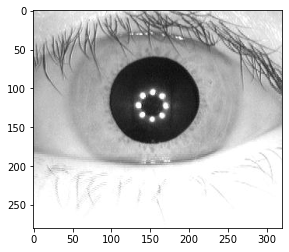

In [68]:
gray_iris = cv2.imread(images[0],cv2.COLOR_BGR2GRAY)
found_row = iris_df.iloc[[0]]

#iris
center_coordinates = (int(found_row[' center_x_2']), int(found_row[' center_y_2']))
radius = int(found_row[' polomer_2'])
mask = np.zeros_like(gray_iris)
mask = cv2.circle(mask,(center_coordinates),radius,(255,255,255),-1)

#pupil
center_coordinates = (int(found_row[' center_x_1']), int(found_row[' center_y_1']))
radius = int(found_row[' polomer_1'])

result = cv2.bitwise_and(gray_iris,mask)
result = cv2.circle(result,(center_coordinates),radius,(0,0,0),-1)

#tie dve viecka
center_coordinates = (int(found_row[' center_x_3']), int(found_row[' center_y_3']))
radius = int(found_row[' polomer_3'])
mask = np.zeros_like(gray_iris)
mask = cv2.circle(mask,(center_coordinates),radius,(255,255,255),-1)
result = cv2.bitwise_and(result,mask)

center_coordinates = (int(found_row[' center_x_4']), int(found_row['center_y_4']))
radius = int(found_row[' polomer_4'])
mask = np.zeros_like(gray_iris)
mask = cv2.circle(mask,(center_coordinates),radius,(255,255,255),-1)
result = cv2.bitwise_and(result,mask)

# result = cv2.bitwise_and(result,mask2)
imshow(result,cmap='gray')